# **Project 3: Team Norman Borlaug**

## **2009-10** File

#### Group Members:
> Mary  -  marylaska@berkeley.edu <br>
> Jack - jackpollard@berkeley.edu<br>
> Jocelyn - jocelynvelazquez@berkeley.edu <br>
> Vivian - yumeng.zhang0502@berkeley.edu <br>
> Steven -  k1519632@berkeley.edu <br>


## Project Setup

In [24]:
#import packages

In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
  Attempting uninstall: CFEDemands
    Found existing installation: CFEDemands 0.6.1
    Uninstalling CFEDemands-0.6.1:
      Successfully uninstalled CFEDemands-0.6.1


In [47]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import cfe.regression as rgsn
import warnings

In [48]:
warnings.filterwarnings('ignore')

# [A] Choice of a dataset and regression set-up

We chose the Uganda dataset because it was one of the most comprehensive in our previous project, offering detailed yearly data. We also identified a relevant nutrition policy in Uganda to analyze, allowing us to assess its impact and suggest policy improvements.

In [3]:
uganda_data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

In [70]:
import cfe

# Define your InputFiles dictionary.

# --------------------------------------------
# YEAR  (2009-10) and Run Cell
#---------------------------------------------

InputFiles = {
    'Expenditures': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2009-10)'), #CHANGE YEAR HERE 2013-14 OR 2019-20
    'Prices': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
    'HH Characteristics': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
    'FCT': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
    'RDI': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),
}


def get_clean_sheet(key, sheet=None):
    """
    Read a sheet from Google Sheets, clean column names and duplicates.
    """
    df = read_sheets(key, sheet=sheet)
    # Strip whitespace from column names.
    df.columns = [c.strip() for c in df.columns.tolist()]
    # Remove duplicate columns, keeping the first occurrence.
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    # Drop columns that start with 'Unnamed'
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    # Drop duplicate rows based on the index.
    df = df.loc[~df.index.duplicated(), :]
    # Also drop any completely duplicate rows.
    df = df.drop_duplicates()
    return df


def load_data(InputFiles):
    """
    Load and preprocess the Expenditures, HH Characteristics, Prices, FCT, and RDI data.
    Returns:
      x: Expenditures DataFrame indexed by ['i','t','m'] with columns 'j'
      z: Household characteristics DataFrame indexed by ['i','t','m']
      p, fct, rdi: Other data sets (if needed for later analysis)
    """
    # Get expenditures
    x = get_clean_sheet(InputFiles['Expenditures'][0],
                        sheet=InputFiles['Expenditures'][1])
    if 'm' not in x.columns:
        x['m'] = 1
    x["i"] = x["i"].astype(str)
    x = x.set_index(['i','t','m'])
    x.columns.name = 'j'
    x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    x = x.replace(0, np.nan)
    
    # Get HH Characteristics
    z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                        sheet=InputFiles['HH Characteristics'][1])
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i','t','m'])
    z.columns.name = 'k'
    z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get Prices (if needed later)
    p = get_clean_sheet(InputFiles['Prices'][0],
                        sheet=InputFiles['Prices'][1])
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t','m'])
    p.columns.name = 'j'
    p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    p = p.replace(0, np.nan)
    
    # Get FCT
    fct = get_clean_sheet(InputFiles['FCT'][0],
                          sheet=InputFiles['FCT'][1])
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get RDI
    rdi = get_clean_sheet(InputFiles['RDI'][0],
                          sheet=InputFiles['RDI'][1])
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    
    return x, z, p, fct, rdi


def prepare_expenditures_for_regression(x):
    """
    Convert the Expenditures DataFrame to a 1D Series (y) for regression.
    This function aggregates duplicate (i,t,m,j) combinations using the mean,
    then takes the natural log.
    """
    # Stack the expenditures so that columns (j) become part of the index.
    # Reset index to make all index levels into columns.
    df_long = x.stack().reset_index(name='expenditure')
    # Now, if duplicates exist in (i,t,m,j), aggregate them.
    df_agg = df_long.groupby(['i', 't', 'm', 'j'])['expenditure'].mean().reset_index()
    # Set the multi-index again.
    y = df_agg.set_index(['i', 't', 'm', 'j'])['expenditure']
    # Take the log of expenditures.
    y_log = np.log(y)
    return y_log


def run_regression(x, z):
    """
    Prepare the data and run the regression of log(expenditures) on household characteristics.
    Returns the regression result from cfe.
    """
    # Prepare y (dependent variable)
    y_log = prepare_expenditures_for_regression(x)
    
    # Run the regression.
    result = cfe.Regression(y=y_log, d=z)
    return result


# =============================================================================
# Call of the functions:
# =============================================================================

# Load all data.
x, z, p, fct, rdi = load_data(InputFiles)

# preview of data:
#display(x.head())
#display(z.head())
#display(p.head())
#display(fct.head())
#display(rdi.head())

# Run  regression.
result = run_regression(x, z)

# Display sorted regression coefficients.
beta_sorted = result.get_beta().sort_values(ascending=False)
#print(beta_sorted.head(20))


In [71]:
result.to_pickle('./foo.pickle')

In [72]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [73]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          106476.993449
Protein           2165.478473
Fiber             2009.072054
Folate           21064.797450
Calcium          28684.337182
Carbohydrate     19616.140712
Iron               835.493006
Niacin             753.466964
Riboflavin          66.299184
Thiamin             77.429589
Vitamin A        17935.227646
Vitamin B-12        68.797926
Vitamin B-6        170.007659
Vitamin C        14992.000232
Zinc               398.351343
dtype: float64

In [74]:
yhat = result.get_predicted_log_expenditures()

# [A] Estimate Demand System

### Setting up demand system from project 3

In [80]:

def process_data_per_year(uganda_data, year):
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(uganda_data, sheet=sheet_expend)
    x["i"] = x["i"].astype(str)
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(uganda_data, sheet=sheet_prices).set_index(['t', 'm', 'j', 'u'])
    p = p.groupby(['t', 'm', 'j', 'u']).median()
    
    # Directly select prices in kilograms
    p = p.xs('Kg', level='u').squeeze().unstack('j')
    # Align to only the goods you estimated
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(uganda_data, sheet="Household Characteristics")
    d = d[d.t == year]
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    d.set_index(['i', 't', 'm'], inplace=True)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    x = x.replace(0, np.nan)
    y = np.log(x)
    
    return x, y, d


# --------------------------------------------
# YEAR (2009-10) and Run Cell
#---------------------------------------------
x, y, d = process_data_per_year(uganda_data,"2009-10")

#print("Food Expenditures (x)")
#display(x.head())

#print("Household Characteristics (d)")
#display(d.head())

#print("Log of Expenditures (y)")
#isplay(y.head())

In [81]:
result.predicted_expenditures()

i           t        m        j             
1013000201  2009-10  Central  Beans              2862.805019
                              Beef               5177.391930
                              Bread              2957.838367
                              Cabbages            725.187395
                              Cassava            2495.331637
                                                    ...     
4193003510  2009-10  Western  Sugar              5828.781737
                              Sweet Bananas      5298.538559
                              Sweet Potatoes    14762.647172
                              Tea                 750.807756
                              Tomatoes           2401.653351
Length: 96530, dtype: float64

In [82]:
result = rgsn.Regression(y=y,d=d)

In [83]:
beta = result.get_beta()
#beta.head

In [84]:
gamma = result.get_gamma()
#gamma.head

### Saving Result

In [86]:
result.to_pickle('uganda_estimates_2009.rgsn')

In [87]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates_2009.rgsn')


### **New Code Starts Here**

#### Reference Prices

In [88]:
col_prices = p.mean(axis=0)

pbar = col_prices.groupby(level='j').mean()

# Keep only the goods you have betas for, fill missing with 1
pbar = pbar.reindex(result.beta.index).fillna(1)

def my_prices(p0, j, p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p


#### Budgets

In [89]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities 

In [90]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#qhat.head(4)

In [91]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands

#### Demand Functions -  how quantity demanded responds to price changes at different budget percentiles.

In [92]:
%matplotlib inline


Text(0.5, 0, 'Quantities of Maize (flour) Demanded')

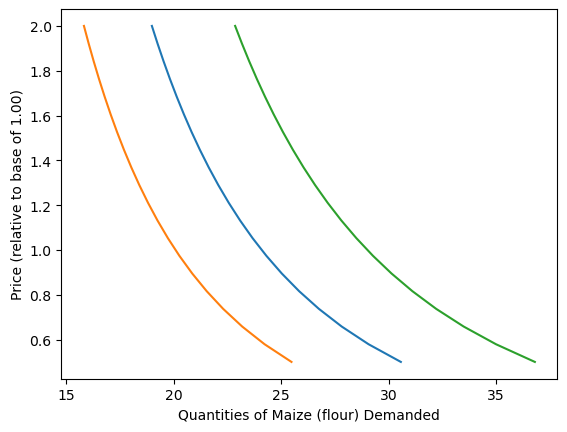

In [93]:
import matplotlib.pyplot as plt

use = 'Maize (flour)'  # CHANGE FOOD TYPE HERE

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand  for household at median budget
plt.plot([result.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves - how expenditure shares change with income.

Text(0.5, 1.0, 'Engel Curves')

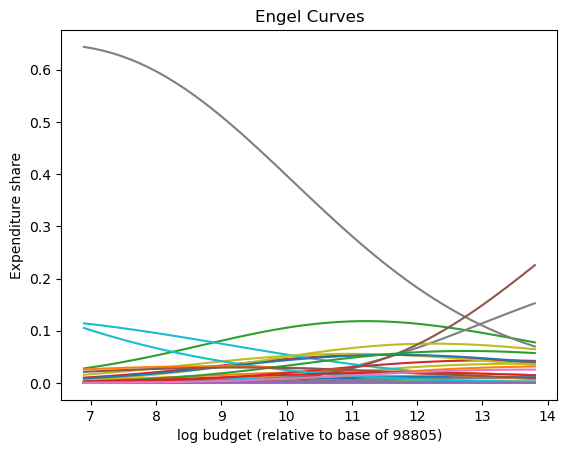

In [94]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

# [A] Construct Nutrient System

#### Mapping to Nutrients

In [95]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beans (dry)', 'Beans (fresh)', 'Beef', 'Bread', 'Cassava (fresh)',
       'Cooking Oil', 'Dodo', 'Eggs', 'Fresh Fish', 'Ground Nuts (pounded)',
       'Ground Nuts (shelled)', 'Mangos', 'Millet', 'Onions', 'Oranges',
       'Passion Fruits', 'Sim Sim', 'Sorghum', 'Sugar', 'Sweet Bananas',
       'Sweet Potatoes (fresh)', 'Tomatoes'],
      dtype='object', name='j')


In [96]:
N = fct0.T@c0

N.head()  #NB: Uganda quantities are for previous 7 days

i,1013000201,1013000204,1013000206,101300021302,1021000102,1021000108,1021000109,1021000110,1021000111,1021000113,...,4193003208,4193003210,4193003211,4193003212,4193003502,4193003503,4193003504,4193003506,4193003508,4193003510
t,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,...,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10
m,Central,Central,Central,Central,Central,Central,Central,Central,Central,Central,...,Western,Western,Western,Western,Western,Western,Western,Western,Western,Western
n,,,,,,,,,,,,,,,,,,,,,
Energy,4.252031e+07,5.085405e+07,4.631386e+07,4.226501e+07,6.485814e+07,6.565379e+07,6.572981e+07,1.001623e+08,8.666973e+07,1.080147e+08,...,6.856346e+07,7.410625e+07,4.951229e+07,4.923411e+07,1.668099e+08,1.077506e+08,4.612827e+07,1.902337e+08,5.090537e+07,1.968943e+08
Protein,2.360851e+06,2.804624e+06,2.535928e+06,2.319010e+06,3.665150e+06,3.611813e+06,3.617967e+06,5.805361e+06,4.511182e+06,5.931056e+06,...,3.843417e+06,4.152106e+06,2.743094e+06,2.650188e+06,8.958145e+06,6.084583e+06,2.580521e+06,1.038551e+07,2.792986e+06,1.090839e+07
Fiber,9.738564e+05,1.187127e+06,9.634684e+05,9.492347e+05,1.439862e+06,1.589965e+06,1.429394e+06,2.240938e+06,2.075486e+06,2.407227e+06,...,1.879746e+06,2.150337e+06,1.319355e+06,1.535968e+06,4.058760e+06,2.682931e+06,1.285451e+06,5.139937e+06,1.433715e+06,5.373515e+06
Folate,2.179079e+07,2.657383e+07,2.198087e+07,2.145122e+07,3.235479e+07,3.677058e+07,3.076339e+07,5.222915e+07,4.593403e+07,5.437240e+07,...,4.564608e+07,5.393257e+07,3.149597e+07,3.824719e+07,9.295312e+07,6.294937e+07,3.075927e+07,1.276604e+08,3.502861e+07,1.332890e+08
Calcium,9.056596e+06,1.096598e+07,9.157368e+06,8.845553e+06,1.355056e+07,1.444042e+07,1.357339e+07,2.084519e+07,1.907664e+07,2.255793e+07,...,1.634820e+07,1.838185e+07,1.163031e+07,1.290669e+07,3.700603e+07,2.429825e+07,1.119422e+07,4.491789e+07,1.237868e+07,4.682171e+07


In [97]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Text(0, 0.5, 'log nutrient')

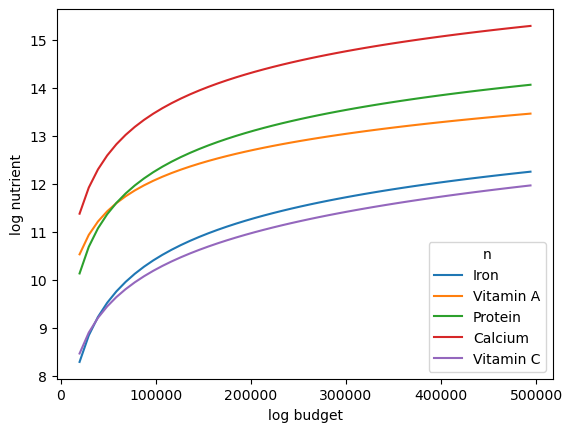

In [98]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

#--------------------------
#ADD OR CHANGE NUTRIENTS HERE
#----------------------------
UseNutrients = ['Iron', 'Vitamin A', 'Protein', 'Calcium', 'Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Text(0, 0.5, 'log nutrient')

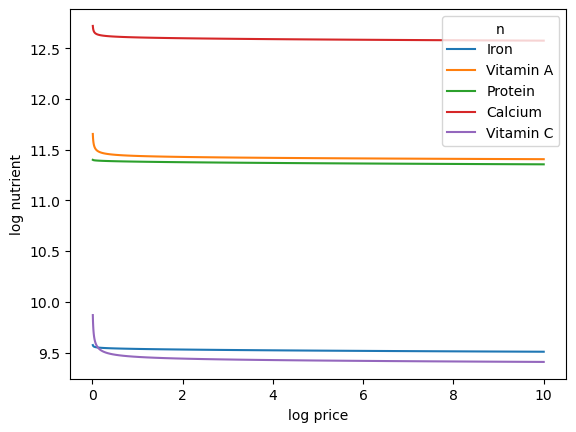

In [99]:
#--------------------------------------
#Pick a food high ion Vitamin A and Iron
#----------------------------------------

USE_GOOD = 'Dodo'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

#### Nutritional Needs of Households

In [100]:
# In first round, averaged over households and villages
columns_to_average = [col for col in d.columns if col.startswith('Females') or col.startswith('Males')]

dbar = d[columns_to_average].mean()

In [101]:
rdi_renamed = rdi.copy()
rdi_renamed.columns = rdi_renamed.columns.to_series() \
    .str.replace('^F ', 'Females ', regex=True) \
    .str.replace('^M ', 'Males ', regex=True) \
    .str.replace('51\\+', '51-99', regex=True)

# Reorder columns to match dbar index
rdi_aligned = rdi_renamed[dbar.index]

# Matrix multiply
hh_rdi = rdi_aligned @ dbar   # example: for 7 days
hh_rdi

n
Energy          10179.623403
Protein           223.121385
Fiber             142.514728
Folate           1884.431742
Calcium          6265.332885
Carbohydrate      765.924681
Iron               62.606254
Magnesium        1602.030935
Niacin             72.034970
Phosphorus       4754.031607
Potassium       25390.080699
Riboflavin          5.636785
Thiamin             5.481473
Vitamin A        3757.061197
Vitamin B-12       11.306590
Vitamin B-6         6.200605
Vitamin C         333.589442
Vitamin E          70.216543
Vitamin K         444.909213
Zinc               45.674849
dtype: float64

In [102]:
rdi_aligned.head()


k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99
n,,,,,,,,,,,,,,
Energy,1000.0,1200.0,1600.0,1800.0,2000.0,1800.0,1600.0,1000.0,1400.0,1800.0,2200.0,2400.0,2200.0,2000.0
Protein,13.0,19.0,34.0,46.0,46.0,46.0,46.0,13.0,19.0,34.0,52.0,56.0,56.0,56.0
Fiber,14.0,16.8,22.4,25.2,28.0,25.2,22.4,14.0,19.6,25.2,30.8,33.6,30.8,28.0
Folate,150.0,200.0,300.0,400.0,400.0,400.0,400.0,150.0,200.0,300.0,400.0,400.0,400.0,400.0
Calcium,700.0,1000.0,1300.0,1300.0,1000.0,1000.0,1200.0,700.0,1000.0,1300.0,1300.0,1000.0,1000.0,1000.0


In [103]:
dbar

k
Females 00-03    0.355414
Females 04-08    0.483188
Females 09-13    0.482851
Females 14-18    0.412576
Females 19-30    0.541022
Females 31-50    0.472091
Females 51-99    0.245461
Males 00-03      0.375588
Males 04-08      0.475454
Males 09-13      0.494956
Males 14-18      0.422327
Males 19-30      0.484869
Males 31-50      0.439139
Males 51-99      0.206792
dtype: float64

### Nutritional Adequacy of Food Demands


In [104]:
def nutrient_adequacy_ratio(x, p, d, rdi = rdi_aligned, days=7):
    # 1) copy & rename RDI columns so they line up with d.index
    rdi_clean = rdi.copy()
    rdi_clean.columns = (
        rdi_clean.columns
        .to_series()
        .str.replace('F ', 'Females ', regex=False)
        .str.replace('M ', 'Males ',   regex=False)
    )
    rdi_clean.columns = rdi_clean.columns.str.replace('51\\+', '51–99', regex=True)

    # 2) replace any blank entries with zero
    rdi_clean = rdi_clean.replace('', 0)

    # 3) re-order (and fill) so that columns == d.index
    #    any missing columns become zeros
    rdi_aligned = rdi_clean.reindex(columns=d.index, fill_value=0)

    # 4) compute household RDI and divide demand by it
    hh_rdi = (rdi_aligned @ d) * days
    return nutrient_demand(x, p) / hh_rdi


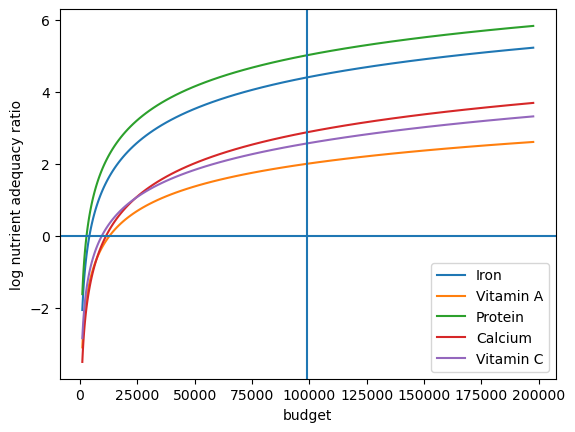

In [105]:
X = np.geomspace(.01 * xref, 2 * xref, 100)

pd.DataFrame({
    x: np.log(nutrient_adequacy_ratio(x, pbar, dbar, rdi))[UseNutrients] for x in X
}).T.plot()

plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)


Text(0.5, 0, 'log nutrient adequacy ratio')

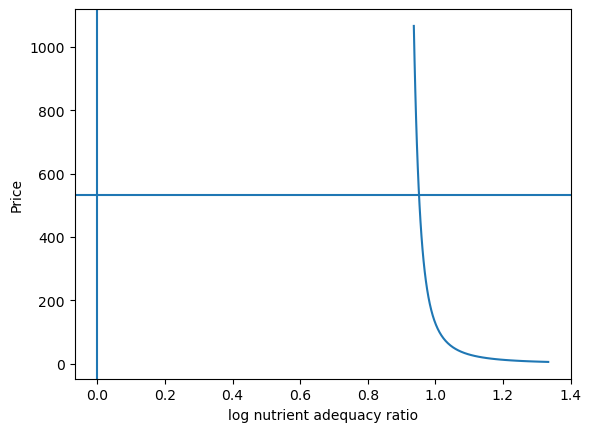

In [106]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

# [A] Nutritional challeneges & Policy Goal

### use example costs notebook Arpil 22nd

In [108]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rdi.index.to_numpy())

nutrient_ratio = (nutrients[use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2009-10,Central,0.948354,0.953596,1.208902,1.050136,0.436820,2.071797,1.185074,0.908719,1.207164,1.084082,0.444976,0.776891,2.319631,2.917228,0.818969
1013000204,2009-10,Central,1.013364,0.923990,1.297503,1.115584,0.436215,2.329798,1.195615,0.979088,1.202776,1.177146,0.468511,0.662099,2.592948,3.433642,0.812684
1013000206,2009-10,Central,1.025440,1.002021,1.263760,1.180044,0.499379,1.933427,1.159917,0.881475,1.407537,1.018507,0.629893,1.002733,2.317165,3.539164,0.818007
101300021302,2009-10,Central,0.943181,0.980372,1.139307,1.053558,0.447254,1.910659,1.149515,0.872234,1.281540,1.051248,0.490588,0.955234,2.209014,2.745356,0.825096
1021000102,2009-10,Central,1.451331,1.314323,1.778458,1.503572,0.623865,3.011398,1.639006,1.315147,1.727812,1.492971,0.675517,1.213199,3.300215,4.299645,1.138763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193003504,2009-10,Western,1.204475,1.268761,1.593419,1.208279,0.455653,3.270210,1.742723,1.279510,1.323252,1.788790,0.428938,0.682431,3.241755,4.708443,1.091887
4193003506,2009-10,Western,2.855179,2.739540,4.217164,3.267037,1.153567,7.526003,3.578744,3.089747,3.457587,3.971259,1.235746,2.164600,8.986093,13.146415,2.472091
4193003507,2009-10,Western,2.246162,2.310040,3.341205,2.508258,0.955641,5.895691,3.054334,2.412439,2.832142,3.072850,1.174561,1.479722,6.247353,10.269026,1.930446


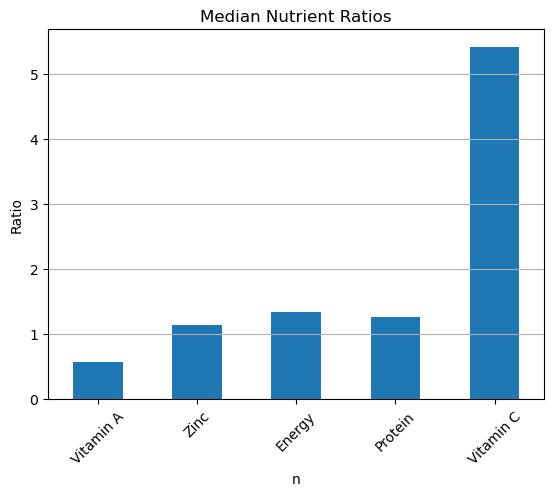

In [110]:
import matplotlib.pyplot as plt

selected_nutrients = ['Vitamin A','Zinc', 'Energy', 'Protein', 'Vitamin C']
nutrient_means = nutrient_ratio[nutrient_ratio[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()

# [B] Policy Options

# [C] Policy Costs

In [55]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Marshallian vs. Hicksian Demand Curves


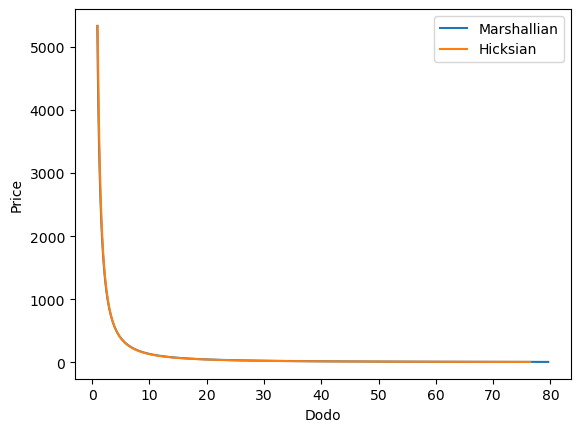

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Dodo'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = result.indirect_utility(x0,pbar)

plt.plot([result.demands(x0,my_prices(my_j,p0))[my_j] for p0 in P],P)
plt.plot([result.demands(U0,my_prices(my_j,p0),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare Measures

In [57]:
def compensating_variation(U0,p0,p1):
    x0 = result.expenditure(U0,p0)
    x1 = result.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = result.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation



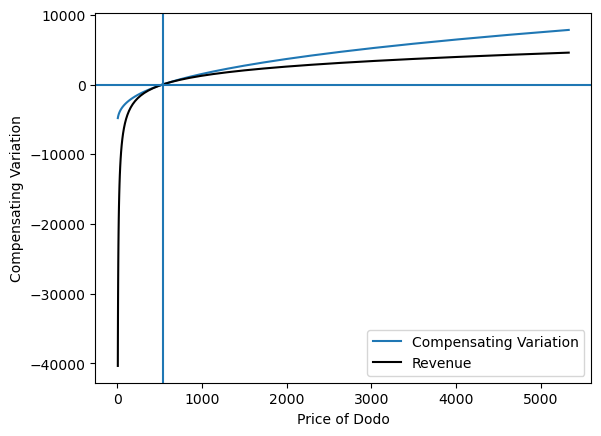

In [58]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(my_j,p0),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss


Text(0, 0.5, 'Deadweight Loss')

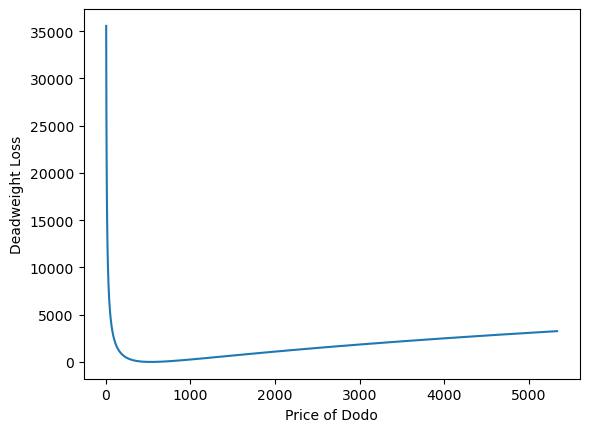

In [59]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")

# [C] Value of Technical Innovation